# Alternative respiration methods


In [1]:
# add root directory to python path
import sys, os
if os.path.join(sys.path[0], '..') not in sys.path:
    sys.path.insert(1, os.path.join(sys.path[0], '..'))

# perform imports
import time
import copy
import numpy as np
import matplotlib.pyplot as plt
from sweeprecon.io.ImageData import ImageData

from sklearn.metrics.cluster import normalized_mutual_info_score
from scipy.stats import wasserstein_distance

# load image data and crop slices to reduce processing time
image_path = 'data/IMG_3D_cropped_0247.nii.gz'

Image = ImageData(image_path)
print(Image.img.shape)

Image.square_crop(crop_z=[50,450])

# Check shape
print(Image.img.shape)
plt.imshow(Image.img[:,:,1])

(384, 154, 608)
rect not defined defaulting to full FOV
(384, 154, 402)


In [ ]:
Image.img.shape

In [ ]:
from skimage.feature import register_translation
from scipy import signal

#from skimage.metrics import structural_similarity as ssim
from skimage.measure import compare_ssim

# one off test no loops
img_resp = Image.img[50:100,50:100,:]  # anterior patch with resp
img_static = Image.img[300:350,0:50,:]  # patch with no resp

plt.imshow(Image.img[:,:,1])

test = 50
kern = 25

error = np.zeros(len(np.arange(test-kern,test+kern)))
diffphase = np.zeros(len(np.arange(test-kern,test+kern)))

ssim_resp = np.zeros(len(np.arange(test-kern,test+kern)))
ssim_static = np.zeros(len(np.arange(test-kern,test+kern)))

ssd_resp = np.zeros(len(np.arange(test-kern,test+kern)))
ssd_static = np.zeros(len(np.arange(test-kern,test+kern)))

nmi_resp = np.zeros(len(np.arange(test-kern,test+kern)))
nmi_static = np.zeros(len(np.arange(test-kern,test+kern)))

cc_resp = np.zeros(len(np.arange(test-kern,test+kern)))
cc_static = np.zeros(len(np.arange(test-kern,test+kern)))


def sumsd(img1, img2):
    return np.sum((img1 - img2) ** 2)

def nmi(img1, img2, bins=128):
    hist_2d, x_edges, y_edges = np.histogram2d(img1.ravel(),img2.ravel(),bins=bins)
    pxy = hist_2d / float(np.sum(hist_2d))
    px = np.sum(pxy, axis=1) # marginal for x over y
    py = np.sum(pxy, axis=0) # marginal for y over x
    px_py = px[:, None] * py[None, :] # Broadcast to multiply marginals
    # Now we can do the calculation using the pxy, px_py 2D arrays
    nzs = pxy > 0 # Only non-zero pxy values contribute to the sum
    return np.sum(pxy[nzs] * np.log(pxy[nzs] / px_py[nzs]))

def normcrosscor(img1, img2):
    # implement from wiki cross correlation
    sigm1 = np.std(img1)
    sigm2 = np.std(img2)
    npix = img1.size
    return (1/npix) * np.sum( (1/(sigm1*sigm2)) * img1 * img2)

def znormcrosscor(img1, img2):
    # implement from wiki cross correlation
    sigm1 = np.std(img1)
    sigm2 = np.std(img2)
    mu1 = np.mean(img1)
    mu2 = np.mean(img2)
    npix = img1.size
    return (1/npix) * np.sum( (1/(sigm1*sigm2)) * (img1-mu1) * (img2-mu2))
    
    
for nn, zz in enumerate(range(test - kern, test+kern)):
    #shift, error[nn], diffphase[nn] = register_translation(img[:,:,test], img[:,:,zz])
    #cc[:,:,nn] = signal.correlate2d(img[:,:,test], img[:,:,zz])
    ssim_resp[nn] = compare_ssim(img_resp[:,:,zz], img_resp[:,:,test], gaussian_weights=True, sigma=3)
    ssim_static[nn] = compare_ssim(img_static[:,:,zz], img_static[:,:,test], gaussian_weights=True, sigma=3)
    
    ssd_resp[nn] = sumsd(img_resp[:,:,zz], img_resp[:,:,test])
    ssd_static[nn] = sumsd(img_static[:,:,zz], img_static[:,:,test])
    
    nmi_resp[nn] = nmi(img_resp[:,:,zz], img_resp[:,:,test])
    nmi_static[nn] = nmi(img_static[:,:,zz], img_static[:,:,test])
    
    cc_resp[nn] = znormcrosscor(img_resp[:,:,zz], img_resp[:,:,test])
    cc_static[nn] = znormcrosscor(img_static[:,:,zz], img_static[:,:,test])

In [ ]:
import statsmodels.api as sm
from scipy.signal import medfilt

from math import ceil

def lowess_sm(x, y, filt_dist_mm=5, iter=5):
    lowess = sm.nonparametric.lowess
    kern = ceil(filt_dist_mm / Image.nii.header["pixdim"][3])
    kern_frac = kern / len(y)
    x = np.arange(0, y.shape[0])
    yest = lowess(y, x, frac=kern_frac, it=iter)
    return yest[:,1]

def medfilt_dist(x, y, filt_dist_mm=5,):
    kern = int(filt_dist_mm / Image.nii.header["pixdim"][3])
    kern = int(np.ceil(kern) // 2 * 2 + 1)  # round up to nearest odd n
    print(kern)
    return medfilt(y, kernel_size=kern)


In [ ]:

import scipy.stats as stats

x = np.linspace(0, 2*kern, 2*kern)

def gausswindow(x, mu):
    window = stats.norm.pdf(x, mu, mu/3)
    return ((window - np.min(window)) / (np.max(window) - np.min(window)))
    
def linwindow(x,mu):
    # linear ramp up down - doesnt work atm come back to this probably not usefuls
    return np.concat(np.linspace(0,1,mu), np.linspace(1,0,mu))
    
window = gausswindow(x, kern)
plt.plot(x,window)

In [ ]:
# delete refernce slice
fig, ax = plt.subplots(3, 2, sharex='col', figsize=(15, 10))
filt_dist_mm=8

ax[0,0].set_title('resp sim measures')
ax[0,0].plot(nmi_resp,'g.-')
ax[0,0].plot(ssim_resp,'b.-')
ax[0,0].plot(cc_resp,'r.-')
#ax[0,0].set_ylim([-0.1, 0.8])

ax[0,1].set_title('static sim measures')
ax[0,1].plot(nmi_static,'g.-')
ax[0,1].plot(ssim_static,'b.-')
ax[0,1].plot(cc_static,'r.-')
#ax[0,1].set_ylim([0, 1.0])

ax[1,0].set_title('resp sim measures - windowed')
#ax[1,0].plot(nmi_resp*window,'g.-')
#ax[1,0].plot(ssim_resp*window,'b.-')
ax[1,0].plot((cc_resp*window),'r.-')
ax[1,0].plot(medfilt_dist(x, cc_resp*window, filt_dist_mm=filt_dist_mm))
ax[1,0].set_ylim([0, 1.2])

ax[1,1].set_title('static sim measures - windowed')
#ax[1,1].plot(ssim_static*window,'b.-')
ax[1,1].plot(cc_static*window,'r.-')
ax[1,1].plot(medfilt_dist(x, cc_static*window, filt_dist_mm=filt_dist_mm))
ax[1,1].set_ylim([0, 1.2])

local_sim_resp = (cc_resp*window) - medfilt_dist(x, cc_resp*window, filt_dist_mm=filt_dist_mm)
local_sim_static = (cc_static*window) - medfilt_dist(x, cc_static*window, filt_dist_mm=filt_dist_mm)

ax[2,0].plot(local_sim_resp,'k.-')
ax[2,0].set_title('local sim resp')

ax[2,1].plot(local_sim_static,'k.-')
ax[2,1].set_title('local sim static')

___
Test on full volume

In [2]:
# Formalise for volume
import time
import copy
from scipy.signal import medfilt, medfilt2d
import scipy.stats as stats
from scipy.ndimage.filters import gaussian_filter
from skimage.exposure import equalize_adapthist
import statsmodels.api as sm
from skimage import restoration
from skimage.feature import register_translation
from skimage.feature import match_template


class local_sim(object):
    
    def __init__(self, Image, local_patch_size, windowed=False, filter=True):
        self.Image = Image
        self.img = copy.deepcopy(Image.img)
        self.sim_img = np.zeros((Image.img.shape[0], Image.img.shape[1],Image.img.shape[2], Image.img.shape[2]), dtype=np.float32)
        self.local_patch_size = local_patch_size
        self.img_local = np.zeros((local_patch_size[0], local_patch_size[1],Image.img.shape[2]))
        self.window = np.ones((local_patch_size[2],), dtype=int)
        self.sim_matrix = np.zeros((local_patch_size[2], local_patch_size[2],))
        self.kern = int(self.local_patch_size[0]/2)
        self.cc_resp = np.zeros(self.local_patch_size[2])
        if windowed:
            self.linear_window()
            plt.plot(self.window)
            plt.title('local window')
            plt.show()
        print(self.sim_img.shape)
        if filter:
            print('Filtering input')
            for zz in range(0, self.img.shape[2]):
                #self.img[:,:,zz] = equalize_adapthist(self.img[:,:,zz].astype('uint16'), clip_limit=0.05)
                self.img[:,:,zz] = gaussian_filter(self.img[:,:,zz], 1.25)
                #self.img[:,:,zz] = restoration.denoise_tv_bregman(self.img[:,:,zz], weight=0.002)
                #self.img[:,:,zz] = medfilt2d(self.img[:,:,zz], kernel_size=3)
                
    def extract_local_patch(self,xx,yy):
        xs = np.arange(xx - self.local_patch_size[0]/2, xx + self.local_patch_size[0]/2).astype(int)
        ys = np.arange(yy - self.local_patch_size[1]/2, yy + self.local_patch_size[1]/2).astype(int)
        self.img_local[:,:,:] = self.img[xs, ys, :]
        
    def local_sim(self, xx, yy):
        # loop over target slices
        for tt in range(0, self.img_local.shape[2]-1):
            # loop over test slices
            _offset1 = 0
            _offset2 = self.local_patch_size[2]
            for nn, zz in enumerate(range(tt - int(self.local_patch_size[2]/2), tt + int(self.local_patch_size[2]/2))):
                if (zz < 0):
                    self.cc_resp[nn] = 0
                    _offset1 += 1
                elif (zz > self.sim_img.shape[2]-1):
                    self.cc_resp[nn] = 0   
                    _offset2 += -1
                else:
                    self.cc_resp[nn] = self.reg_cc_trans(self.img_local[:,:,zz], self.img_local[:,:,tt])
                    
            #sim_v = (self.cc_resp - self.lowess_sm(range(0,len(self.cc_resp)), self.cc_resp)) * self.window
            sim_v = (self.cc_resp) * self.window

            #sim_v = self.cc_resp - self.medfilt_dist_mm(np.linspace(0, self.local_patch_size[0], self.local_patch_size[0]), self.cc_resp)) * self.window
            
            # sim_v = self.cc_resp * self.window # - offset
            #print(sim_v.shape)
            #print(range(_offset1,_offset2))
            self.sim_img[xx, yy, tt, range(max(0, tt - int(self.local_patch_size[2]/2)), min(tt + int(self.local_patch_size[2]/2), self.sim_img.shape[2]))] = sim_v[range(_offset1,_offset2),]  #.clip(min=0)  # set negative values to 0
    
    def second_diff(self, v):
        return np.gradient(np.gradient(v))  
    
    def linear_window(self, notch=False):
        x = np.linspace(0, self.local_patch_size[2], self.local_patch_size[2]).astype(int)
        if notch:
            self.window = np.interp(x, np.array([0, self.local_patch_size[2]/2, self.local_patch_size[2]-1]) , np.array([1, .2, 1]))
        else:               
            self.window = np.interp(x, np.array([0, self.local_patch_size[2]/2, self.local_patch_size[2]]) , np.array([0.8, 1, 0.8]))
    
    def gauss_window(self, std_mm=1, notch=False):
        std = std_mm / self.Image.nii.header["pixdim"][3]
        x = np.linspace(0, self.local_patch_size[2], self.local_patch_size[2])
        window = stats.norm.pdf(x, self.local_patch_size[2]/2, std)
        self.window = ((window - np.min(window)) / (np.max(window) - np.min(window)))
        if notch:
            self.window = 0.1 + np.ones(window.shape) - ((window - np.min(window)) / (np.max(window) - np.min(window)))  
        
    def sumsd(self, img1, img2):
        return np.nansum((img1 - img2).ravel() ** 2)
    
    def reg_cc_trans(self, img1, img2):
        shift, error, diffphase = register_translation(img1, img2)
        #return (shift[0]**2 + shift[1]**2)**0.5
        return error
    
    def absdiff(self, img1, img2):
        return np.sum(np.abs(img1.ravel() - img2.ravel()))
    
    def znormcrosscor(self, img1, img2):
        # implement from wiki cross correlation
        return (1/img1.size) * np.sum( (1/(np.std(img1.ravel())*np.std(img2.ravel()))) * (img1.ravel()-np.mean(img1.ravel())) * (img2.ravel()-np.mean(img2.ravel())))    
    
    def crosscor(self, img1, img2):
        # implement from wiki cross correlation
        return (1/img1.size) * np.sum( (1/(np.std(img1.ravel())*np.std(img2.ravel()))) * (img1.ravel()) * (img2.ravel()))   
    
    def nmi(self, img1, img2, bins=16):
        hist_2d, x_edges, y_edges = np.histogram2d(img1.ravel(),img2.ravel(),bins=bins)
        pxy = hist_2d / float(np.sum(hist_2d))
        px = np.sum(pxy, axis=1) # marginal for x over y
        py = np.sum(pxy, axis=0) # marginal for y over x
        px_py = px[:, None] * py[None, :] # Broadcast to multiply marginals
        # Now we can do the calculation using the pxy, px_py 2D arrays
        nzs = pxy > 0 # Only non-zero pxy values contribute to the sum
        return np.sum(pxy[nzs] * np.log(pxy[nzs] / px_py[nzs]))

    def medfilt_dist_mm(self, x, y, filt_dist_mm=5,):
        kern = int(filt_dist_mm / Image.nii.header["pixdim"][3])
        kern = int(np.ceil(kern) // 2 * 2 + 1)  # round up to nearest odd n
        return medfilt(y, kernel_size=kern)
    
    def lowess_sm(self, x, y, filt_dist_mm=4, iter=5):
        kern = int(filt_dist_mm / Image.nii.header["pixdim"][3])
        kern_frac = kern / len(y)
        x = np.arange(0, y.shape[0])
        yest = sm.nonparametric.lowess(y, x, frac=kern_frac, it=iter)
        return yest[:,1]
    
    def optimal_slices(self, sample_density=0.0015):
        nsx = sample_density * self.img.shape[0]
        nsy = sample_density * self.img.shape[1]
        
        self.sx = np.linspace(int(self.local_patch_size[0]/2), self.img.shape[0] - int(self.local_patch_size[0]/2), nsx).astype(int)
        self.sy = np.linspace(int(self.local_patch_size[1]/2), self.img.shape[1] - int(self.local_patch_size[1]/2), nsy).astype(int)
        self.sx = np.array([128])
        self.sy = np.array([64])
        print('calculating sim measure for %d patches' % (len(self.sx) * len(self.sy)))
        for xx in self.sx:
            for yy in self.sy:
                print((xx,yy))
                self.extract_local_patch(xx,yy)
                self.local_sim(xx,yy)
        sz
        # for each x(sample_density)
        # for each y(sample_density)
        # extract local region
        # for ecah t(all)
        # define local sim and store
        
        # interpolate slice density
        # find optimal interpolation weights for coherent volume
        
        return

In [3]:
#del localsim
import gc
gc.collect() 

if 'localsim' in locals():
    print('clearing old localsim')
    del localsim

gc.collect()

local_def = (128,128,128)
localsim = local_sim(Image, local_def, windowed=False, filter=True)
slices = localsim.optimal_slices()

(384, 154, 402, 402)
Filtering input
calculating sim measure for 1 patches
(128, 64)


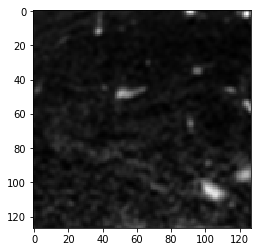

In [4]:
test_patch = (128, 64, 100)  # resp

xs = np.arange(test_patch[0] - local_def[0]/2, test_patch[0] + local_def[0]/2).astype(int)
ys = np.arange(test_patch[1] - local_def[1]/2, test_patch[1] + local_def[1]/2).astype(int)
zs = np.arange(test_patch[2] - local_def[2]/2, test_patch[2] + local_def[2]/2).astype(int)

plt.imshow( localsim.img[xs[0]:xs[-1], ys[0]:ys[-1], test_patch[2]], cmap='gray')

In [ ]:
# test OF
import cv2 as cv
import SimpleITK as sitk

nvs = 2

mot_v = np.zeros((nvs,))
ssd_v = np.zeros((nvs,))

img1ARR = localsim.img[xs[0]:xs[-1], ys[0]:ys[-1], test_patch[2]]
img1 = sitk.GetImageFromArray(localsim.img[xs[0]:xs[-1], ys[0]:ys[-1], test_patch[2]])
R = sitk.ImageRegistrationMethod()
R.SetMetricAsMeanSquares()
R.SetOptimizerAsRegularStepGradientDescent(4.0, .01, 200 )
R.SetInitialTransform(sitk.AffineTransform(img1.GetDimension()))
R.SetInterpolator(sitk.sitkLinear)

for ii in range(0,nvs):
    img2ARR = localsim.img[xs[0]:xs[-1], ys[0]:ys[-1], test_patch[2] + ii]
    img2 = sitk.GetImageFromArray(localsim.img[xs[0]:xs[-1], ys[0]:ys[-1], test_patch[2] + ii])
    demons = sitk.DemonsRegistrationFilter()
    demons.SetNumberOfIterations( 50 )
    
    # Standard deviation for Gaussian smoothing of displacement field
    demons.SetStandardDeviations( 1.0 )
    displacementField = demons.Execute( img1, img2 )
    displacementField_img = sitk.GetArrayFromImage(displacementField)
    #print(outTx.GetParameters())
    #mot_v[ii] = np.linalg.norm([outTx.GetParameters()[-2], outTx.GetParameters()[-1]])
    #outfield = displacementField.GetDisplacementField()

    #pyr_scale = 0.5
    #levels = 1
    #winsize = 5
    #iterations = 5
    #poly_n = 5
    #poly_sigma = 1.1
    #flow = cv.calcOpticalFlowFarneback(img1, img2, None, pyr_scale, levels, winsize, iterations,poly_n, poly_sigma, 0)

    
print(displacementField_img.shape)

aff = np.array(outTx.GetParameters())

fig, ax = plt.subplots(1, 4, sharex='col', figsize=(30, 10))
ax[0].imshow(img1ARR)
ax[1].imshow(img2ARR)
ax[2].imshow(img1ARR-img2ARR)
ax[3].imshow((displacementField_img[:,:,1]**2 + displacementField_img[:,:,1]**2)**0.5)


In [ ]:
# test
import matplotlib.patches as patches
import statsmodels.api as sm

def lowess_sm(x, y, filt_dist_mm=5, iter=5):
    #lowess = sm.nonparametric.lowess
    kern = int(filt_dist_mm / Image.nii.header["pixdim"][3])
    kern_frac = kern / len(y)
    x = np.arange(0, y.shape[0])
    yest = sm.nonparametric.lowess(y, x, frac=kern_frac, it=iter)
    return yest[:,1]

def gauss_window(local_patch_size, Image, std_mm=1.0, notch=False):
        std = std_mm / Image.nii.header["pixdim"][3]
        x = np.linspace(0, local_patch_size[2], local_patch_size[2])
        window = stats.norm.pdf(x, local_patch_size[2]/2, std)
        window = ((window - np.min(window)) / (np.max(window) - np.min(window)))
        if notch:
            window = 0.1 + np.ones(window.shape) - ((window - np.min(window)) / (np.max(window) - np.min(window)))
        return window

#test_patch = (357, 119, 20)  # static
#test_patch = (102, 81, 100)  # resp

fig, ax = plt.subplots(1, 3, sharex='col', figsize=(20, 5))

x_local = range( max(0, test_patch[2]-int(local_def[2]/2)), min(localsim.sim_img.shape[2], test_patch[2]+int(local_def[2]/2)) )

print(x_local)

vv = np.squeeze(localsim.sim_img[test_patch[0],test_patch[1],test_patch[2],:])

ax[0].plot(vv, '.-')
ax[0].plot(x_local, lowess_sm(x_local, vv[x_local]), '.-')

#ax[0].plot(vv - medfilt_dist_mm(np.linspace(0, local_def[0], local_def[0]), vv), '.-')
#ax[0].plot(np.squeeze(localsim.sim_img[test_patch_stat[0],test_patch_stat[1],test_patch_stat[2],:]), '.-')

ax[1].plot(x_local, vv[x_local], 'o-')

ax[2].imshow(localsim.img[:, :, test_patch[2]])
rect1 = patches.Rectangle((test_patch[1]-(local_def[1]/2),test_patch[0]-(local_def[0]/2)),local_def[1],local_def[0],linewidth=1,edgecolor='w',facecolor='none')
ax[2].add_patch(rect1)
#rect2 = patches.Rectangle((test_patch_stat[1]-(local_def[1]/2),test_patch_stat[0]-(local_def[0]/2)),local_def[1],local_def[0],linewidth=1,edgecolor='r',facecolor='none')
#ax[2].add_patch(rect2)

ax[0].grid()
ax[0].set_xticks(np.arange(0,Image.img.shape[2]+1,10))
#ax[0].plot(0.8+-1*np.gradient( np.gradient(localsim.sim_img[test_patch[0],test_patch[1],test_patch[2],:],)),'.-')

In [5]:
X = np.linspace(0, local_def[2], local_def[2]).astype(int)

#Y = (vv[x_local] - lowess_sm(x_local, vv[x_local])) * window
Y = vv[x_local] 

plt.plot(Y)
#Y = np.squeeze(localsim.sim_img[test_patch[0],test_patch[1],test_patch[2],:])

Z = np.argsort(Y)

ii = 0
xs = np.arange(test_patch[0] - local_def[0]/2, test_patch[0] + local_def[0]/2).astype(int)
ys = np.arange(test_patch[1] - local_def[1]/2, test_patch[1] + local_def[1]/2).astype(int)
zs = np.arange(test_patch[2] - local_def[2]/2, test_patch[2] + local_def[2]/2).astype(int)

#plt.plot(Y[Z])

print(Z)

NameError: name 'vv' is not defined

In [ ]:
ii=0

In [ ]:
fig, ax = plt.subplots(1, 4, sharex='col', figsize=(20, 6))

print(test_patch[2] - int(local_def[2]/2) + Z[ii])

ax[0].imshow( localsim.img[xs[0]:xs[-1], ys[0]:ys[-1], test_patch[2] - int(local_def[2]/2) + Z[ii]], cmap='gray')
ax[3].imshow( localsim.img[xs[0]:xs[-1], ys[0]:ys[-1], test_patch[2] - int(local_def[2]/2) + Z[0]] - localsim.img[xs[0]:xs[-1], ys[0]:ys[-1], test_patch[2] - int(local_def[2]/2) + Z[ii]])
#plt.clim(-0.8,0.8)

x = np.arange(0, Image.img.shape[2])

ax[2].plot(x_local,Y, '.-')
#ax[2].plot(x_local,np.squeeze(localsim.sim_img[test_patch[0],test_patch[1],test_patch[2],:]), '.-')

ax[2].plot(x_local[Z[ii]],Y[Z[ii]], 'o-')

ax[2].grid()
#ax[2].set_xticks(np.arange(0,Image.img.shape[2] + 1 ,10))
ax[3].set_title(str(Z[ii])+' ' + str(ii) )

ax[1].imshow( localsim.img[xs[0]:xs[-1], ys[0]:ys[-1], test_patch[2] - int(local_def[2]/2) + Z[0]], cmap='gray')

ii = ii + 1

In [ ]:
# save most similar slices as nifti
patchrect = np.array( [ [test_patch[1] - int(local_def[1]/2), test_patch[0] - int(local_def[0]/2)], [test_patch[1] + int(local_def[1]/2), test_patch[0] + int(local_def[0]/2)]])
print(patchrect)
name = '_'.join(map(str, test_patch)) 
print(name)

ImageCrop = copy.deepcopy(Image)
ImageCrop.square_crop(rect=patchrect)
img = Image.img[xs[0]:xs[-1], ys[0]:ys[-1], test_patch[2] - int(local_def[2]/2) + Z[:]]
ImageCrop.set_data(img)
ImageCrop.write_nii(('sorted_slice_%s.nii.gz' % name))

ImageCrop_diff = copy.deepcopy(Image)
ImageCrop_diff.square_crop(rect=patchrect)
img_diff = np.zeros(img.shape)
for ii in range(0, local_def[2]):
    img_diff[:,:,ii] = Image.img[xs[0]:xs[-1], ys[0]:ys[-1], test_patch[2] - int(local_def[2]/2) + Z[ii]] - Image.img[xs[0]:xs[-1], ys[0]:ys[-1], test_patch[2] - int(local_def[2]/2) + Z[0]] 

ImageCrop_diff.set_data(img_diff)
ImageCrop_diff.write_nii(('sorted_slice_%s_diff.nii.gz' % name))

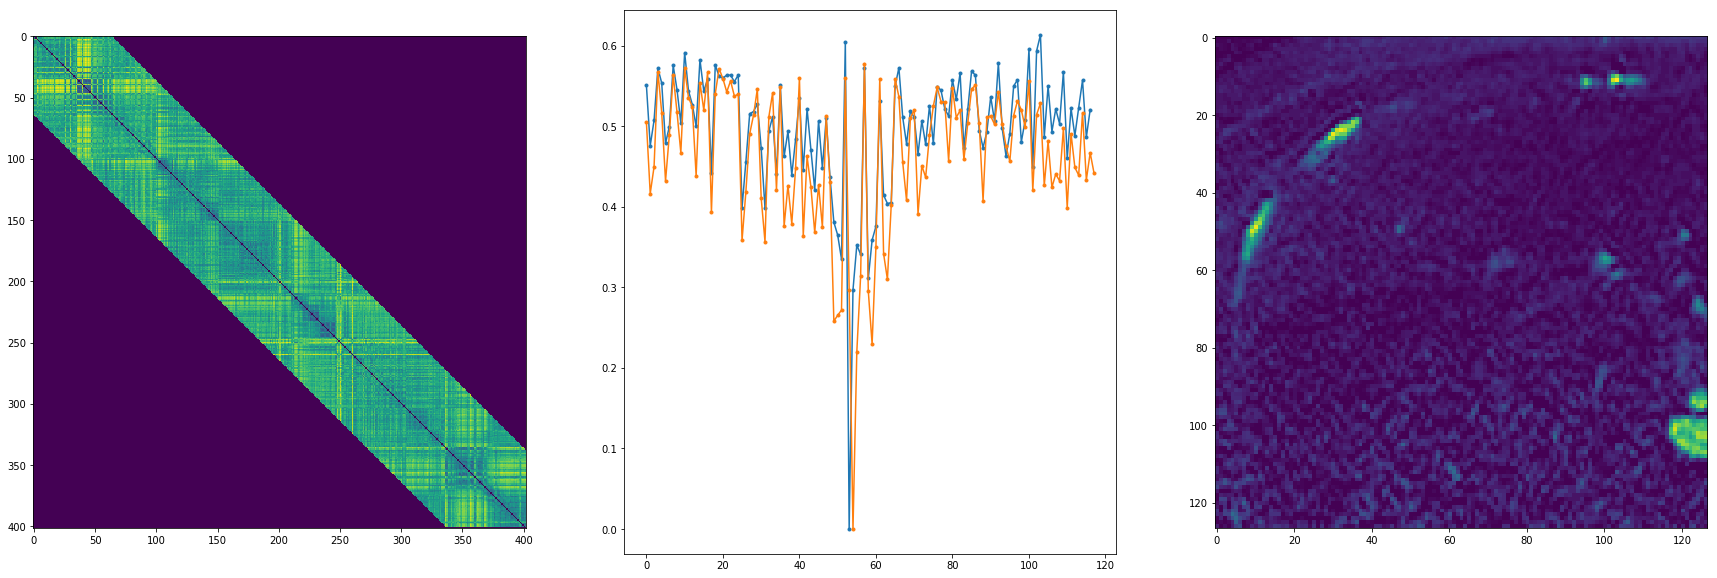

In [12]:
# visualise as slice vs slice
sim_mat1 = np.squeeze(localsim.sim_img[test_patch[0], test_patch[1],:,:])

sim_mat_norm = np.zeros(sim_mat1.shape)
for ii in range(0, sim_mat_norm.shape[0]):
    vx = sim_mat1[:,ii]
    sim_mat_norm[ii,:] = ((vx - np.min(vx)) / (np.max(vx) - np.min(vx)))
    
fig, ax = plt.subplots(1, 3, sharex='col', figsize=(30, 10))

sim_mat1 = sim_mat1
ax[0].imshow(sim_mat1)

for test_slice in range(53,55):
    x_local = range( max(0, test_slice-int(local_def[2]/2)), min(localsim.sim_img.shape[2], test_slice+int(local_def[2]/2)) )
    ax[1].plot(x_local,np.squeeze(sim_mat1[test_slice,x_local]),'.-')

ax[2].imshow(Image.img[xs[0]:xs[-1], ys[0]:ys[-1], test_slice])


In [13]:
# save sim_mat as mat
import scipy.io as sio
sio.savemat('adjacency_mat_nmi.mat', mdict={'sim_mat1': sim_mat1})

In [ ]:
# Find a coherent volume
# Choose a seed slice (n) then find the most similar slice (n2) - then the most similar slice to n2 (n3) etc until n is found again. Use this subset to interpolate a volume.

def find_slices_nearest_min(seed_slice, sim_mat1, inc=0):
    coherent_slices = np.array([])
    current_slice = seed_slice
    while seed_slice not in coherent_slices:
        sim = np.squeeze(sim_mat1[current_slice,:])
        slices = np.argsort(sim) # if not using SSD this must be changed
        sorted_slices = slices[sim[slices]>0]
        sorted_slices = sorted_slices[sorted_slices>current_slice] # move candidate forwards
        
        if not sorted_slices.size>inc:
            break
            
        #current_slice = sorted_slices[0] 
        current_slice = np.min(sorted_slices[0:inc+1]) # nearest slice to current slice
        
        coherent_slices = np.append(coherent_slices, (sorted_slices[0:inc+1])).astype(int) # adding two most similar slices here?
        #coherent_slices = np.append(coherent_slices, current_slice).astype(int) # adding nearest slice in inc
        
    # add seed on at end
    coherent_slices = np.append(coherent_slices, seed_slice).astype(int)
    return coherent_slices

#def find_slices_nearest_min_two_way_notfinish(seed_slice, sim_mat1, inc=0):
#    coherent_slices = np.array([])
#    current_slice = seed_slice
#    while seed_slice not in coherent_slices:
#        sim = np.squeeze(sim_mat1[current_slice,:])
#        slices = np.argsort(sim) # if not using SSD this must be changed
#        sorted_slices = slices[sim[slices]>0]
#        # sorted_slices = sorted_slices[sorted_slices>current_slice] # move candidate forwards
#        if not sorted_slices.size>inc:
#            break
#        current_slice = sorted_slices[0]
#        if current_slice not in coherent_slices:
#            coherent_slices = np.append(coherent_slices, (sorted_slices[0:inc+1])).astype(int) # adding two most similar slices here?
#    # add seed on at end
#    coherent_slices = np.append(coherent_slices, seed_slice).astype(int)
#    return coherent_slices

fig, ax = plt.subplots(1, 2, sharex='col', figsize=(25, 10))

for ii in range(0,sim_mat1.shape[0]):
    ax[0].plot(np.unique(find_slices_nearest_min(ii, sim_mat1, inc=0)),'.-')
    ax[0].set_xlim([0,10])
    ax[0].set_ylim([0,100])

#c1 = np.array([idx for idx, val in enumerate(sim_diff) if val > 0])
c1 = np.unique(find_slices_nearest_min(0, sim_mat1, inc=0))
c2 = np.unique(find_slices_nearest_min(0, sim_mat1, inc=1))
c3 = np.unique(find_slices_nearest_min(0, sim_mat1, inc=2))

print(c1)
print(c2)
print(c3)

print(c1.shape)
print(c2.shape)
print(c3.shape)

ax[1].plot(c1, np.zeros(c1.shape)+0,'.')
ax[1].plot(c2, np.zeros(c2.shape)+1,'.')
ax[1].plot(c3, np.zeros(c3.shape)+2,'.')


[ 11  12  18  22  23  26  31  36  39  43  46  50  51  52  54  65  68  69
  74  77  78  87  92  93  94  95  99 101 104 113 118 120 122 126 130 134
 138 140 146 150 153 154 159 161 162 168 170 179 183 184 186 193 196 197
 204 207 212 213 216 220 225 228 231 232 236 240 243 244 252 255 260 264
 265 277 280 281 282 290 291 293 295 303 305 307 311 317 318 319 326 334
 338 342 343 344 352 358 361 362 369 375 377 382 389 390 397 398 401 408
 416 419 420 424 429 433 436 441 442 450 453 454 462 467 476 481 482 486
 494 495 500 514 515 518 524 528 531 535 536 546 547 548 558 562 566 567
 571 572 573 580 581 584 591 592 595]


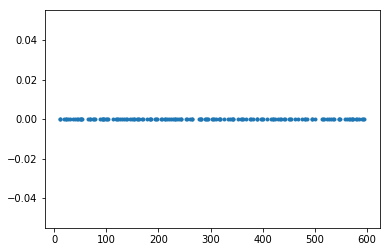

In [19]:
# read c1 from csv
from numpy import genfromtxt
c1 = genfromtxt('core.csv', delimiter=',').astype(int)
print(c1)
plt.plot(c1, np.zeros(c1.shape)+0,'.')


In [21]:
# save interp to nifti with geom
#numpy.interp(xq, x, y, left=None, right=None, period=None)
# proper iso interp

from scipy import interpolate

slices_ind = c1-1

_dxyz = np.array([Image.nii.header['pixdim'][1], Image.nii.header['pixdim'][1], Image.nii.header['pixdim'][1]])
nslices = int((Image.nii.header['pixdim'][3] * Image.nii.header['dim'][3]) / _dxyz[2])
_zq = np.linspace(0, (_dxyz[2] * (nslices-1)), nslices)  # z-query points
_slice_locations = Image.slice_positions()

def _write_resampled_data(image_obj, _dxyz, path):
    """Saves re-sampled image"""
    # TODO: can only correct for interpolation in z at the moment
    image_obj.nii.affine[:, 2] = Image.nii.affine[:, 2] * (_dxyz[2] / Image.nii.header['pixdim'][3])
    image_obj.write_nii(path)
    
xq = np.arange(0,Image.img.shape[2])
zs = (_slice_locations[slices_ind, ]).flatten()  # z-sample points  
interp_vol = np.zeros(np.array([Image.img.shape[0], Image.img.shape[1], (Image.nii.header['pixdim'][3] * Image.nii.header['dim'][3]) / _dxyz[2]]).astype(int))

for xx in xs:
    for yy in ys:
        y = Image.img[xx, yy, slices_ind].flatten()
        f = interpolate.interp1d(zs, y, kind='linear', fill_value="extrapolate")
        interp_vol[xx,yy,:] = f(_zq)
        #interp_vol[xx,yy,:] = np.interp(_zq, zs, y)

name = '_'.join(map(str, test_patch)) 
Image_interp = copy.deepcopy(Image)
Image_interp.set_data(interp_vol)
_write_resampled_data(Image_interp, _dxyz, ('interp_%s.nii.gz' % name))

IndexError: index 407 is out of bounds for axis 0 with size 402

In [ ]:
# np array with shape (frames, height, width, channels)
#video = Image.img[xs[0]:xs[-1], ys[0]:ys[-1], c1]
video = interp_vol
fig = plt.figure()
im = plt.imshow(video[:,:,0])
plt.close() # this is required to not display the generated image
def init():
    im.set_data(video[:,:,0])
def animate(i):
    im.set_data(video[:,:,i])
    return im
anim = animation.FuncAnimation(fig, animate, init_func=init, frames=video.shape[2],
                               interval=100)
HTML(anim.to_html5_video())